### File for looking at indices of conf/correct events to see how many are neutral class. 
## Europe.

8/18/2025

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import collections

In [2]:
def daily_anomaly(target):
    dailymean = np.nanmean(target,axis=1)
    anom = np.zeros_like(target)
    for t in np.arange(target.shape[1]):
         anom[:,t] = target[:,t] - dailymean
    print(anom.shape)
    return anom; 

#_________________________________________________________________
##this instance is just to save the keys so that I can look at composites ... for those dates. 
def compare_keys(list1, list2):
    list1_count = collections.Counter() ##RF counter dictionary
    for day in list1:
        list1_count[day] += 1
    list2_count = collections.Counter() ##LSTM counter dictionary
    for day in list2:
        list2_count[day] += 1
        
    result = []
    list1only = []
    #begin comparing RF and LSTM dictionaries. 
    for key in list1_count:
        if key in list2_count:
            #save the key to look at for composites
            result.append(key)
        if key not in list2_count:
            list1only.append(key)
    
    list2only =[]
    for key in list2_count:
        if key not in list1_count:
            list2only.append(key)
    
    ##I have this set up to look at the SLTM/RF only values too but I may save those for another time. 
    return result, list1only, list2only;
#ultimately these composites would look at the average across the # of shared dates, ignoring the count of them. 

In [3]:
##process ellipse diags.
##open ellipse metric files
infile = open("../../data/ellipse/wind10_redo.p", 'rb') 
wind10 = pickle.load(infile)
infile.close()

infile = open("../../data/ellipse/size10_redo.p", 'rb') 
size10 = pickle.load(infile)
infile.close()

infile = open("../../data/ellipse/ratio10_redo.p", 'rb') 
rat10 = pickle.load(infile)
infile.close()

infile = open("../../data/ellipse/ephi10_redo.p", 'rb') 
ephi10 = pickle.load(infile)
infile.close()

infile = open("../../data/ellipse/cenlat10_redo.p", 'rb')
cenlat10 = pickle.load(infile)
infile.close()

infile = open("../../data/ellipse/cenlon10_redo.p", 'rb')
cenlon10 = pickle.load(infile)
infile.close()

infile = open("../../data/gph/NA_gph_weightedANOM_100.p", 'rb') 
gph = pickle.load(infile)
infile.close()

infile = open("../../data/pv/CAP_pvu_weightedANOM.p", 'rb') 
pv = pickle.load(infile)
infile.close()

#remove leap year
##CHANGE IF NOT EXTENDED DATAQ BACK TO 120
wind10 = np.delete(wind10[:62],[151],1)
rat10 = np.delete(rat10[:62],[151],1)
cenlat10 = np.delete(cenlat10[:62],[151],1)
cenlon10 = np.delete(cenlon10[:62],[151],1)
size10 = np.delete(size10[:62],[151],1)
ephi10 = np.delete(ephi10[:62],[151],1)

shift = 14
#this is used to change the start date from October 19 to November 2nd... and just reduce the overall time observed.
#0 if no change. 

idx = 135

wind10 = wind10[:,19+shift:168]
rat10 = rat10[:,19+shift:168]
cenlat10 = cenlat10[:,19+shift:168]
cenlon10 = cenlon10[:,19+shift:168]
size10 = size10[:,19+shift:168]
ephi10 = ephi10[:,19+shift:168]
gph = gph[:62,19+shift:168]
pv = pv[:62,19+shift:168]

#remove NaNs
##CHANGE IF NOT EXTENDED DATA
test_comp = []
indices = np.isnan(wind10)
for i in range(0,62):
    for j in range(0,idx):
        if indices[i,j] != False:
            wind10[i,j] = 0
            rat10[i,j] = 0
            cenlat10[i,j] = 0
            cenlon10[i,j] = 0
            size10[i,j] = 0
            ephi10[i,j] = 0
            if i >= 57:
                test_comp.append((i,j))
            else:
                continue
                
input2 = np.empty((62,idx,4))

input2[:,:,2] = daily_anomaly(cenlat10[:62,:])
input2[:,:,1] = daily_anomaly(cenlon10[:62,:])
input2[:,:,3] = daily_anomaly(wind10[:62,:])
input2[:,:,0] = daily_anomaly(gph[:62,:])

(62, 135)
(62, 135)
(62, 135)
(62, 135)


Open index files and temp files. 

In [4]:
##open indice files
infile = open("../posXtest_eur14.p", 'rb') 
posXtest = pickle.load(infile)
infile.close()

infile = open("../FposXtest_eur14.p", 'rb') 
FposXtest = pickle.load(infile)
infile.close()

infile = open("../negXtest_eur14.p", 'rb') 
negXtest = pickle.load(infile)
infile.close()

infile = open("../FnegXtest_eur14.p", 'rb') 
FnegXtest = pickle.load(infile)
infile.close()

infile = open("../../data/eur_anomtemps_3_15std.p", 'rb') 
temps = pickle.load(infile)
infile.close()

temps = temps.reshape((62,149))
temp = temps[52:,14:]

In [5]:
temp.shape

(10, 135)

### These few cells will be for making box plots instead lol. 

It is important to keep in mind that there are also just proportionally less pos and neg temp extremes left as I increase the classification criterion (i.e., +1.5 std) ... SO regardless of whether they are proportionally more events, there are still less to choose from ... if that makes sense?

In [6]:
##reduce input to just the testing data
nolag_Xtest = input2[52:,:,:]

####now I wanna make these plots SO ... I am adding an index column on to X_test ... full version. 
ranges = np.array([x for x in range(0,135*10,1)])
ranges = ranges.reshape(10,135) 
ranges.shape

(10, 135)

In [7]:
nolag_Xtest.shape

(10, 135, 4)

In [8]:
##Correct Positive Events
posXtest_set = set(posXtest)

negcorr_indices = [] 
poscorr_indices = [] 
neutcorrP_indices = []
pos_corr_events = [] 
neg_corr_events = [] 
neut_corrP_events = []

for i in range(10):
    for j in range(135):
        date_index = ranges[i, j]
        if date_index not in posXtest_set:
            continue
        value = temp[i, j]
        features = nolag_Xtest[i, j, :]
        if value == 0:
            negcorr_indices.append(date_index)
            neg_corr_events.append(features)
        elif value == 1:
            poscorr_indices.append(date_index)
            pos_corr_events.append(features)
        elif value == 2:
            neutcorrP_indices.append(date_index)
            neut_corrP_events.append(features)

print("Number of Positive and Correct, Negative Temp Anoms: ",str(len(poscorr_indices)))
print("Number of Positive and Correct, Neutral Temp Anoms: ",str(len(neutcorrP_indices)))

count, true, neut = compare_keys(poscorr_indices, neutcorrP_indices)
print("There are "+str(len(count))+" shared indices. There are "+str(len(true))+" unique events for True Positives and "+str(len(neut))+" for neutral.")

Tpos = np.array(pos_corr_events)
print(Tpos.shape)

Tpos_N = np.array(neut_corrP_events)
print(Tpos_N.shape)

Number of Positive and Correct, Negative Temp Anoms:  16
Number of Positive and Correct, Neutral Temp Anoms:  210
There are 0 shared indices. There are 16 unique events for True Positives and 210 for neutral.
(16, 4)
(210, 4)


In [9]:
#Correct Negative
negXtest_set = set(negXtest)

negcorr_indices = [] 
poscorr_indices = [] 
neutcorrN_indices = []
pos_corr_events = [] 
neg_corr_events = [] 
neut_corrN_events = []

for i in range(10):
    for j in range(135):
        date_index = ranges[i, j]
        if date_index not in negXtest_set:
            continue
        value = temp[i, j]
        features = nolag_Xtest[i, j, :]
        if value == 0:
            negcorr_indices.append(date_index)
            neg_corr_events.append(features)
        elif value == 1:
            poscorr_indices.append(date_index)
        elif value == 2:
            neutcorrN_indices.append(date_index)
            neut_corrN_events.append(features)

print("Number of Negative and Correct, Negative Temp Anoms: ",str(len(negcorr_indices)))
print("Number of Negative and Correct, Neutral Temp Anoms: ",str(len(neutcorrN_indices)))

count, true, neut = compare_keys(negcorr_indices, neutcorrN_indices)
print("There are "+str(len(count))+" shared indices. There are "+str(len(true))+" unique events for True Negatives and "+str(len(neut))+" for neutral.")

Tneg = np.array(neg_corr_events)
print(Tneg.shape)

Tneg_N = np.array(neut_corrN_events)
print(Tneg_N.shape)

Number of Negative and Correct, Negative Temp Anoms:  45
Number of Negative and Correct, Neutral Temp Anoms:  186
There are 0 shared indices. There are 45 unique events for True Negatives and 186 for neutral.
(45, 4)
(186, 4)


In [10]:
##False Positive Events
FposXtest_set = set(FposXtest)

Fnegcorr_indices = [] 
Fposcorr_indices = [] 
FneutcorrP_indices = [] 

Fpos_corr_events = [] 
Fneg_corr_events = []
Fneut_corrP_events = []

for i in range(10):
    for j in range(135):
        date_index = ranges[i, j]
        if date_index not in FposXtest_set:
            continue
        value = temp[i, j]
        features = nolag_Xtest[i, j, :]
        if value == 0:
            Fnegcorr_indices.append(date_index)
            Fneg_corr_events.append(features)
        elif value == 1:
            Fposcorr_indices.append(date_index)
            Fpos_corr_events.append(features)
        elif value == 2:
            FneutcorrP_indices.append(date_index)
            Fneut_corrP_events.append(features)

print("Number of Positive and Incorrect, Negative Temp Anoms: ",str(len(Fnegcorr_indices)))
print("Number of Positive and Incorrect, Neutral Temp Anoms: ",str(len(FneutcorrP_indices)))

count, true, neut = compare_keys(Fnegcorr_indices, FneutcorrP_indices)
print("There are "+str(len(count))+" shared indices. There are "+str(len(true))+" unique events for False Positives and "+str(len(neut))+" for neutral.")

Fpos = np.array(Fneg_corr_events)
print(Fpos.shape)

Fpos_N = np.array(Fneut_corrP_events)
print(Fpos_N.shape)

#False Negative
FnegXtest_set = set(FnegXtest)

Fnegcorr_indices = [] 
Fposcorr_indices = [] 
FneutcorrN_indices = [] 

Fpos_corr_events = [] 
Fneg_corr_events = []
Fneut_corrN_events = []

for i in range(10):
    for j in range(135):
        date_index = ranges[i, j]
        if date_index not in FnegXtest_set:
            continue
        value = temp[i, j]
        features = nolag_Xtest[i, j, :]
        if value == 0:
            Fnegcorr_indices.append(date_index)
            Fneg_corr_events.append(features)
        elif value == 1:
            Fposcorr_indices.append(date_index)
            Fpos_corr_events.append(features)
        elif value == 2:
            FneutcorrN_indices.append(date_index)
            Fneut_corrN_events.append(features)

print("Number of Negative and Incorrect, Positive Temp Anoms: ",str(len(Fposcorr_indices)))
print("Number of Negative and Incorrect, Neutral Temp Anoms: ",str(len(FneutcorrN_indices)))

count, true, neut = compare_keys(Fposcorr_indices, FneutcorrN_indices)
print("There are "+str(len(count))+" shared indices. There are "+str(len(true))+" unique events for False Negatives and "+str(len(neut))+" for neutral.")

Fneg = np.array(Fpos_corr_events)
print(Fneg.shape)

Fneg_N = np.array(Fneut_corrN_events)
print(Fneg_N.shape)

Number of Positive and Incorrect, Negative Temp Anoms:  4
Number of Positive and Incorrect, Neutral Temp Anoms:  72
There are 0 shared indices. There are 4 unique events for False Positives and 72 for neutral.
(4, 4)
(72, 4)
Number of Negative and Incorrect, Positive Temp Anoms:  1
Number of Negative and Incorrect, Neutral Temp Anoms:  103
There are 0 shared indices. There are 1 unique events for False Negatives and 103 for neutral.
(1, 4)
(103, 4)


Next cell has these distributions for both model types. 

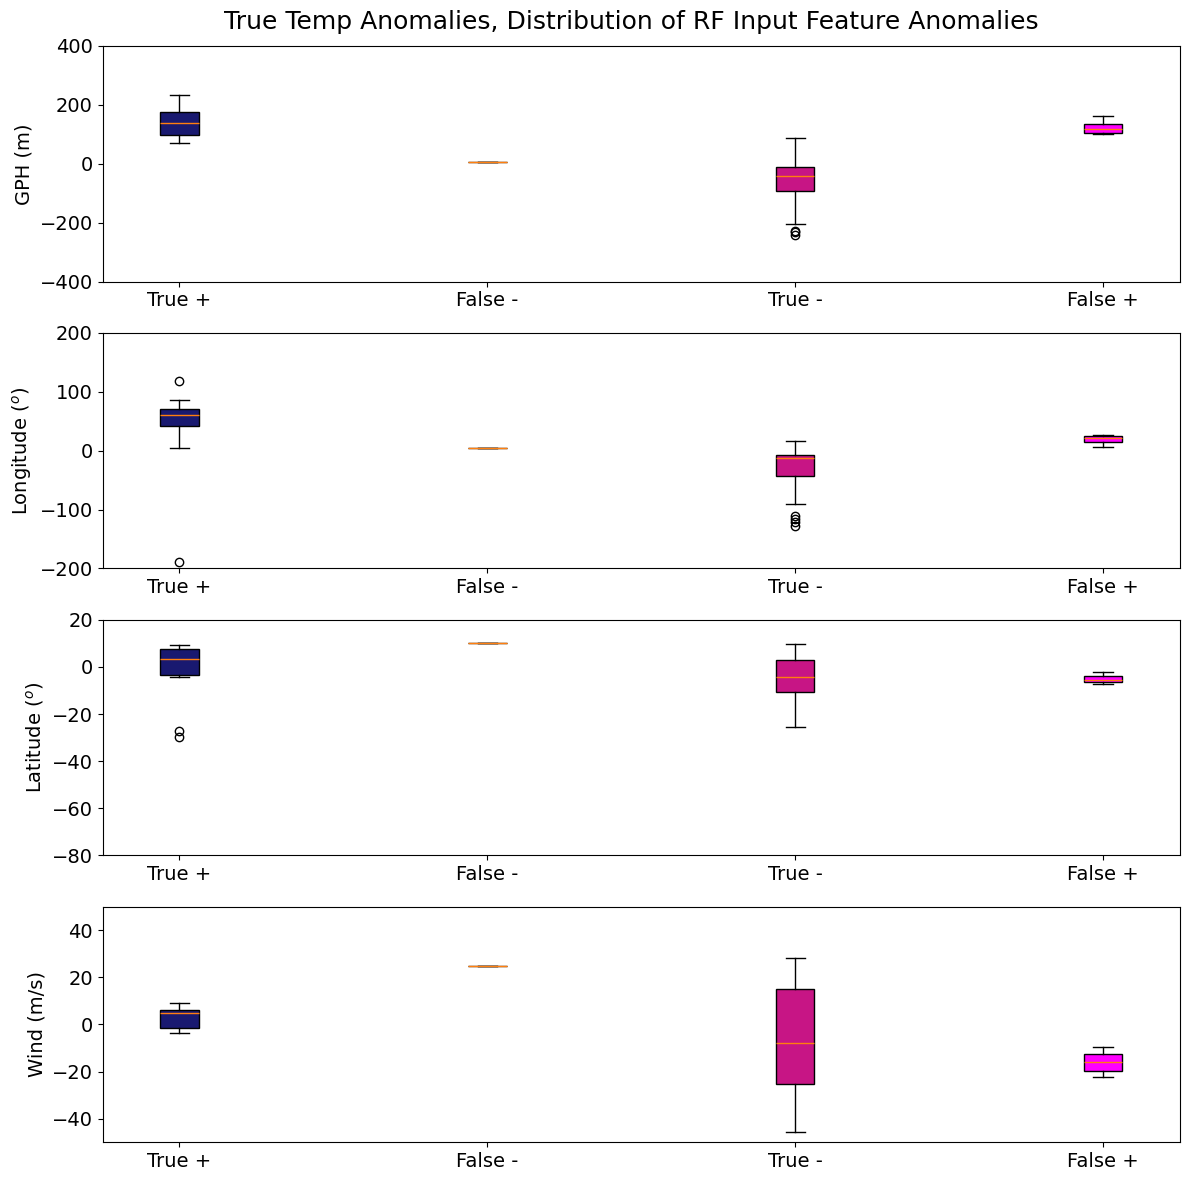

In [11]:
import matplotlib.ticker as mticker
myLocator = mticker.MultipleLocator(2)

#metrics = ["Wind (m/s)", "Ratio (m)", "Latitude ($^o$)", "Longitude ($^o$)", "Size (m$^2$)", "EPhi ($^o$)", "GPH (hPa)", "PV (m$^2$K/s kg)"]
metrics = ["GPH (m)", "Longitude ($^o$)", "Latitude ($^o$)","Wind (m/s)"]
y1 = [-400,-200,-80,-50]
y2 = [400,200,20,50]
ticks = ['True +', 'False -', 'True -', 'False +'] #set tick numbers for dataset
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
c = ["midnightblue","royalblue","mediumvioletred","magenta"]
fs = 14

fig, axes = plt.subplots(4, 1, figsize=(12, 12))
plt.suptitle("True Temp Anomalies, Distribution of RF Input Feature Anomalies", fontsize = 18, x=0.53)
axes = axes.flatten()
for i in range(0,4):
    C_pos = Tpos[:,i]
    F_neg = Fneg[:,i]
    C_neg = Tneg[:,i]
    F_pos = Fpos[:,i]
        
    a1 =axes[i].boxplot([C_pos,F_neg,C_neg,F_pos], positions= [2,4,6,8], widths=w, patch_artist=True)
    for bplot in (a1,):
        for patch, color in zip(bplot['boxes'], c):
            patch.set_facecolor(color)
    axes[i].set_xticks(ind, ticks, fontsize = 14)
    axes[i].set_ylim((y1[i],y2[i]))
    axes[i].set_ylabel(str(metrics[i]), fontsize = 14)
    axes[i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.95)   
plt.savefig("corr_BOXPLOT_test.png",bbox_inches = 'tight')
plt.show()

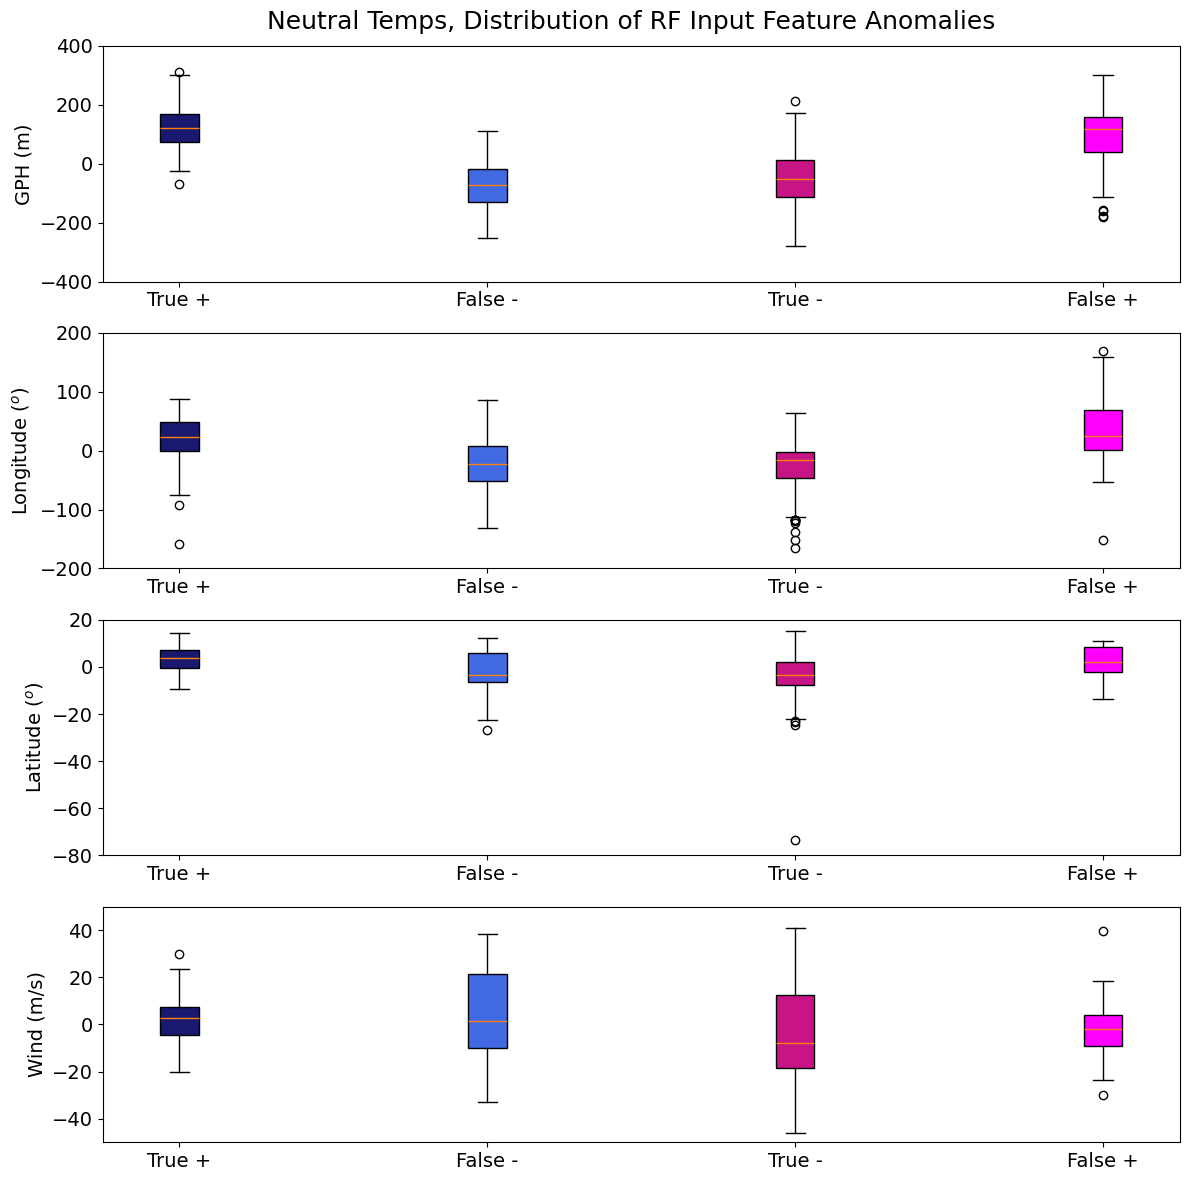

In [13]:
import matplotlib.ticker as mticker
myLocator = mticker.MultipleLocator(2)

#metrics = ["Wind (m/s)", "Ratio (m)", "Latitude ($^o$)", "Longitude ($^o$)", "Size (m$^2$)", "EPhi ($^o$)", "GPH (hPa)", "PV (m$^2$K/s kg)"]
metrics = ["GPH (m)", "Longitude ($^o$)", "Latitude ($^o$)","Wind (m/s)"]
y1 = [-400,-200,-80,-50]
y2 = [400,200,20,50]
ticks = ['True +', 'False -', 'True -', 'False +'] #set tick numbers for dataset
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
c = ["midnightblue","royalblue","mediumvioletred","magenta"]
fs = 14

fig, axes = plt.subplots(4, 1, figsize=(12, 12))
plt.suptitle("Neutral Temps, Distribution of RF Input Feature Anomalies", fontsize = 18, x=0.53)
axes = axes.flatten()
for i in range(0,4):
    C_pos = Tpos_N[:,i]
    F_neg = Fneg_N[:,i]
    C_neg = Tneg_N[:,i]
    F_pos = Fpos_N[:,i]
        
    a1 =axes[i].boxplot([C_pos,F_neg,C_neg,F_pos], positions= [2,4,6,8], widths=w, patch_artist=True)
    for bplot in (a1,):
        for patch, color in zip(bplot['boxes'], c):
            patch.set_facecolor(color)
    axes[i].set_xticks(ind, ticks, fontsize = 14)
    axes[i].set_ylim((y1[i],y2[i]))
    axes[i].set_ylabel(str(metrics[i]), fontsize = 14)
    axes[i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.95)   
plt.savefig("neut_BOXPLOT_test.png",bbox_inches = 'tight')
plt.show()